# Stock value prediction from Open, High, Low

# Import module

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py

Using TensorFlow backend.


# Input parameters 

In [2]:
stock_name = '^GSPC'
seq_len = 22
d = 0.2
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 300

# 1. Download data and normalize it
Data since 1950 to today

In [3]:
def get_stock_data(stock_name, normalize=True):
    start = datetime.datetime(1950, 1, 1)
    end = datetime.date.today()
    df = web.DataReader(stock_name, "yahoo", start, end)
    df.drop(['Volume', 'Close'], 1, inplace=True)
    
    if normalize:        
        min_max_scaler = preprocessing.MinMaxScaler()
        df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
        df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
        df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
        df['Adj Close'] = min_max_scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
    return df

In [4]:
df = get_stock_data(stock_name, normalize=True)
# summarize first 5 rows
print(df.head(5))

                Open      High       Low  Adj Close
Date                                               
1950-01-03  0.000004  0.000000  0.000004   0.000000
1950-01-04  0.000078  0.000074  0.000078   0.000074
1950-01-05  0.000110  0.000106  0.000110   0.000106
1950-01-06  0.000129  0.000125  0.000129   0.000125
1950-01-09  0.000172  0.000168  0.000169   0.000164


# 2. Plot out the Normalized Adjusted close price

In [5]:
def plot_stock(stock_name):
    df = get_stock_data(stock_name, normalize=True)
    print(df.head())
    plt.plot(df['Adj Close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.show()

                Open      High       Low  Adj Close
Date                                               
1950-01-03  0.000004  0.000000  0.000004   0.000000
1950-01-04  0.000078  0.000074  0.000078   0.000074
1950-01-05  0.000110  0.000106  0.000110   0.000106
1950-01-06  0.000129  0.000125  0.000129   0.000125
1950-01-09  0.000172  0.000168  0.000169   0.000164


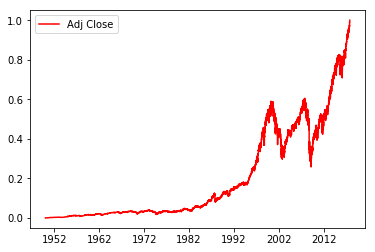

In [6]:
plot_stock(stock_name)

# 3. Set last day Adjusted Close as y

In [7]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    
    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price
    
    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1] 

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [8]:
X_train, y_train, X_test, y_test = load_data(df, seq_len)

In [9]:
X_train.shape[0], X_train.shape[1], X_train.shape[2]

(15335, 22, 4)

In [10]:
y_train.shape[0]

15335

# 4. Buidling neural network

In [11]:
def build_model2(layers, neurons, d):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    # adam = keras.optimizers.Adam(decay=0.2)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# 6. Model Execution

In [21]:
model = build_model2(shape, neurons, d)
# layers = [4, 22, 1]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 22, 128)           68096     
_________________________________________________________________
dropout_3 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.1,
    verbose=1)

Train on 13801 samples, validate on 1534 samples
Epoch 1/300
13801/13801 [==============================] - 19s - loss: 0.0091 - acc: 0.0000e+00 - val_loss: 0.0053 - val_acc: 0.0000e+00
Epoch 2/300
13801/13801 [==============================] - 20s - loss: 4.1204e-04 - acc: 0.0000e+00 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 3/300
13801/13801 [==============================] - 19s - loss: 1.8921e-04 - acc: 0.0000e+00 - val_loss: 4.5630e-04 - val_acc: 0.0000e+00
Epoch 4/300
13801/13801 [==============================] - 20s - loss: 1.4859e-04 - acc: 0.0000e+00 - val_loss: 3.1502e-04 - val_acc: 0.0000e+00
Epoch 5/300
13801/13801 [==============================] - 20s - loss: 1.3470e-04 - acc: 0.0000e+00 - val_loss: 2.7502e-04 - val_acc: 0.0000e+00
Epoch 6/300
13801/13801 [==============================] - 19s - loss: 1.2538e-04 - acc: 0.0000e+00 - val_loss: 2.4122e-04 - val_acc: 0.0000e+00
Epoch 7/300
13801/13801 [==============================] - 18s - loss: 1.1421e-04 - acc: 0.00

13801/13801 [==============================] - 20s - loss: 6.9256e-05 - acc: 0.0000e+00 - val_loss: 1.6756e-04 - val_acc: 0.0000e+00
Epoch 57/300
13801/13801 [==============================] - 20s - loss: 7.5244e-05 - acc: 0.0000e+00 - val_loss: 1.2315e-04 - val_acc: 0.0000e+00
Epoch 58/300
13801/13801 [==============================] - 20s - loss: 7.5652e-05 - acc: 0.0000e+00 - val_loss: 1.1780e-04 - val_acc: 0.0000e+00
Epoch 59/300
13801/13801 [==============================] - 20s - loss: 7.5993e-05 - acc: 0.0000e+00 - val_loss: 2.5360e-04 - val_acc: 0.0000e+00
Epoch 60/300
13801/13801 [==============================] - 19s - loss: 7.0021e-05 - acc: 0.0000e+00 - val_loss: 1.8405e-04 - val_acc: 0.0000e+00
Epoch 61/300
13801/13801 [==============================] - 20s - loss: 6.8316e-05 - acc: 0.0000e+00 - val_loss: 1.5847e-04 - val_acc: 0.0000e+00
Epoch 62/300
13801/13801 [==============================] - 19s - loss: 7.3811e-05 - acc: 0.0000e+00 - val_loss: 1.7920e-04 - val_acc: 0.

13801/13801 [==============================] - 19s - loss: 5.2964e-05 - acc: 0.0000e+00 - val_loss: 9.2523e-05 - val_acc: 0.0000e+00
Epoch 113/300
13801/13801 [==============================] - 19s - loss: 6.3993e-05 - acc: 0.0000e+00 - val_loss: 2.1575e-04 - val_acc: 0.0000e+00
Epoch 114/300
13801/13801 [==============================] - 19s - loss: 5.0215e-05 - acc: 0.0000e+00 - val_loss: 8.9052e-05 - val_acc: 0.0000e+00
Epoch 115/300
13801/13801 [==============================] - 19s - loss: 5.1551e-05 - acc: 0.0000e+00 - val_loss: 8.9702e-05 - val_acc: 0.0000e+00
Epoch 116/300
13801/13801 [==============================] - 19s - loss: 4.8610e-05 - acc: 0.0000e+00 - val_loss: 8.4827e-05 - val_acc: 0.0000e+00
Epoch 117/300
13801/13801 [==============================] - 20s - loss: 4.6071e-05 - acc: 0.0000e+00 - val_loss: 9.6913e-05 - val_acc: 0.0000e+00
Epoch 118/300
13801/13801 [==============================] - 19s - loss: 5.1617e-05 - acc: 0.0000e+00 - val_loss: 8.8872e-05 - val_a

13801/13801 [==============================] - 18s - loss: 4.8898e-05 - acc: 0.0000e+00 - val_loss: 8.0995e-05 - val_acc: 0.0000e+00
Epoch 168/300
13801/13801 [==============================] - 18s - loss: 4.0547e-05 - acc: 0.0000e+00 - val_loss: 6.8751e-05 - val_acc: 0.0000e+00
Epoch 169/300
13801/13801 [==============================] - 19s - loss: 3.5886e-05 - acc: 0.0000e+00 - val_loss: 8.0521e-05 - val_acc: 0.0000e+00
Epoch 170/300
13801/13801 [==============================] - 19s - loss: 3.8390e-05 - acc: 0.0000e+00 - val_loss: 8.7637e-05 - val_acc: 0.0000e+00
Epoch 171/300
13801/13801 [==============================] - 19s - loss: 4.2593e-05 - acc: 0.0000e+00 - val_loss: 1.7974e-04 - val_acc: 0.0000e+00
Epoch 172/300
13801/13801 [==============================] - 18s - loss: 4.1809e-05 - acc: 0.0000e+00 - val_loss: 7.3465e-05 - val_acc: 0.0000e+00
Epoch 173/300
13801/13801 [==============================] - 18s - loss: 3.9760e-05 - acc: 0.0000e+00 - val_loss: 7.9742e-05 - val_a

13801/13801 [==============================] - 19s - loss: 3.1583e-05 - acc: 0.0000e+00 - val_loss: 5.8311e-05 - val_acc: 0.0000e+00
Epoch 223/300
13801/13801 [==============================] - 18s - loss: 3.1790e-05 - acc: 0.0000e+00 - val_loss: 5.9624e-05 - val_acc: 0.0000e+00
Epoch 224/300
13801/13801 [==============================] - 19s - loss: 3.0798e-05 - acc: 0.0000e+00 - val_loss: 5.8020e-05 - val_acc: 0.0000e+00
Epoch 225/300
13801/13801 [==============================] - 19s - loss: 3.0259e-05 - acc: 0.0000e+00 - val_loss: 5.6575e-05 - val_acc: 0.0000e+00
Epoch 226/300
13801/13801 [==============================] - 19s - loss: 3.3945e-05 - acc: 0.0000e+00 - val_loss: 7.1700e-05 - val_acc: 0.0000e+00
Epoch 227/300
13801/13801 [==============================] - 18s - loss: 3.4730e-05 - acc: 0.0000e+00 - val_loss: 5.6186e-05 - val_acc: 0.0000e+00
Epoch 228/300
13801/13801 [==============================] - 20s - loss: 3.3454e-05 - acc: 0.0000e+00 - val_loss: 8.3944e-05 - val_a

13801/13801 [==============================] - 19s - loss: 3.0122e-05 - acc: 0.0000e+00 - val_loss: 1.2027e-04 - val_acc: 0.0000e+00
Epoch 278/300
13801/13801 [==============================] - 19s - loss: 3.3844e-05 - acc: 0.0000e+00 - val_loss: 8.4834e-05 - val_acc: 0.0000e+00
Epoch 279/300
13801/13801 [==============================] - 18s - loss: 2.9367e-05 - acc: 0.0000e+00 - val_loss: 8.0732e-05 - val_acc: 0.0000e+00
Epoch 280/300
13801/13801 [==============================] - 21s - loss: 3.5422e-05 - acc: 0.0000e+00 - val_loss: 7.8360e-05 - val_acc: 0.0000e+00
Epoch 281/300
13801/13801 [==============================] - 19s - loss: 2.6831e-05 - acc: 0.0000e+00 - val_loss: 6.6958e-05 - val_acc: 0.0000e+00
Epoch 282/300
13801/13801 [==============================] - 19s - loss: 3.2445e-05 - acc: 0.0000e+00 - val_loss: 9.1909e-05 - val_acc: 0.0000e+00
Epoch 283/300
13801/13801 [==============================] - 18s - loss: 2.9282e-05 - acc: 0.0000e+00 - val_loss: 6.2358e-05 - val_a

# 7. Result on training set and testing set

In [14]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [15]:
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00002 MSE (0.00 RMSE)
Test Score: 0.00017 MSE (0.01 RMSE)


(1.8758331758155624e-05, 0.0001690568601012453)

# 8. Prediction vs Real results

In [16]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p

In [17]:
p = percentage_difference(model, X_test, y_test)

# 9. Plot out prediction

In [18]:
def denormalize(stock_name, normalized_value):
    start = datetime.datetime(2000, 1, 1)
    end = datetime.date.today()
    df = web.DataReader(stock_name, "yahoo", start, end)
    
    df = df['Adj Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

In [19]:
def plot_result(stock_name, normalized_value_p, normalized_value_y_test):
    newp = denormalize(stock_name, normalized_value_p)
    newy_test = denormalize(stock_name, normalized_value_y_test)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('Days')
    plt2.ylabel('Adjusted Close')
    plt2.show()

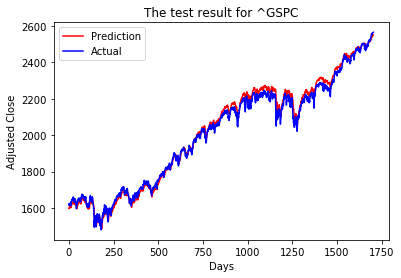

In [20]:
plot_result(stock_name, p, y_test)

# 10. Save for consistency

In [ ]:
# model.save('LSTM_Stock_prediction-20170429.h5')

# Part 2. Fine tune model
# 11. Function to load data, train model and see score

In [ ]:
stock_name = '^GSPC'
seq_len = 22
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 300

In [ ]:
def quick_measure(stock_name, seq_len, d, shape, neurons, epochs):
    df = get_stock_data(stock_name)
    X_train, y_train, X_test, y_test = load_data(df, seq_len)
    model = build_model2(shape, neurons, d)
    model.fit(X_train, y_train, batch_size=512, epochs=epochs, validation_split=0.1, verbose=1)
    # model.save('LSTM_Stock_prediction-20170429.h5')
    trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)
    return trainScore, testScore

# 12. Fine tune hyperparameter

12.1 Optimial Dropout value

In [ ]:
dlist = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
neurons_LSTM = [32, 64, 128, 256, 512, 1024, 2048]
dropout_result = {}

for d in dlist:    
    trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs)
    dropout_result[d] = testScore

In [ ]:
min_val = min(dropout_result.values())
min_val_key = [k for k, v in dropout_result.items() if v == min_val]
print (dropout_result)
print (min_val_key)

In [ ]:
lists = sorted(dropout_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Dropout')
plt.ylabel('Mean Square Error')
plt.show()

12.2 Optimial epochs value

In [ ]:
stock_name = '^GSPC'
seq_len = 22
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochslist = [10,20,30,40,50,60,70,80,90,100]

In [ ]:
epochs_result = {}

for epochs in epochslist:    
    trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs)
    epochs_result[epochs] = testScore

In [ ]:
lists = sorted(epochs_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Epochs')
plt.ylabel('Mean Square Error')
plt.show()

12.3 Optimal number of neurons

In [ ]:
stock_name = '^GSPC'
seq_len = 22
shape = [4, seq_len, 1] # feature, window, output
epochs = 90
dropout = 0.3
neuronlist1 = [32, 64, 128, 256, 512]
neuronlist2 = [16, 32, 64]
neurons_result = {}

for neuron_lstm in neuronlist1:
    neurons = [neuron_lstm, neuron_lstm]
    for activation in neuronlist2:
        neurons.append(activation)
        neurons.append(1)
        trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs)
        neurons_result[str(neurons)] = testScore
        neurons = neurons[:2]    

In [ ]:
lists = sorted(neurons_result.items())
x,y = zip(*lists)

plt.title('Finding the best hyperparameter')
plt.xlabel('neurons')
plt.ylabel('Mean Square Error')

plt.bar(range(len(lists)), y, align='center')
plt.xticks(range(len(lists)), x)
plt.xticks(rotation=90)

plt.show()

12.4 Optimial Dropout value

In [ ]:
stock_name = '^GSPC'
seq_len = 22
shape = [4, seq_len, 1] # feature, window, output
neurons = [256, 256, 32, 1]
epochs = 90
decaylist = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
def build_model3(layers, neurons, d, decay):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
def quick_measure(stock_name, seq_len, d, shape, neurons, epochs, decay):
    df = get_stock_data(stock_name)
    X_train, y_train, X_test, y_test = load_data(df, seq_len)
    model = build_model3(shape, neurons, d, decay)
    model.fit(X_train, y_train, batch_size=512, epochs=epochs, validation_split=0.1, verbose=1)
    # model.save('LSTM_Stock_prediction-20170429.h5')
    trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)
    return trainScore, testScore

In [ ]:
decay_result = {}

for decay in decaylist:    
    trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs, decay)
    decay_result[decay] = testScore

In [ ]:
lists = sorted(decay_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Decay')
plt.ylabel('Mean Square Error')
plt.show()

In [ ]:
stock_name = '^GSPC'
neurons = [256, 256, 32, 1]
epochs = 90
d = 0.3 #dropout
decay = 0.4

In [ ]:
seq_len_list = [5, 10, 22, 60, 120, 180]

seq_len_result = {}

for seq_len in seq_len_list:
    shape = [4, seq_len, 1]
    
    trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs, decay)
    seq_len_result[seq_len] = testScore

In [ ]:
lists = sorted(seq_len_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Days')
plt.ylabel('Mean Square Error')
plt.show()